In [1]:
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
data_dir = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification'

In [4]:
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
model = models.resnet18()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model.load_state_dict(torch.load('/kaggle/input/resnet18forbeans/pytorch/default/1/resnet18_bean_disease.pth', weights_only=True))
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.0001)

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/25 - Loss: 0.2339, Accuracy: 0.9768
Validation Loss: 0.1533, Validation Accuracy: 0.9520

Epoch 2/25 - Loss: 0.0719, Accuracy: 0.9871
Validation Loss: 0.1455, Validation Accuracy: 0.9551

Epoch 3/25 - Loss: 0.0576, Accuracy: 0.9859
Validation Loss: 0.1424, Validation Accuracy: 0.9567

Epoch 4/25 - Loss: 0.0491, Accuracy: 0.9861
Validation Loss: 0.1457, Validation Accuracy: 0.9505

Epoch 5/25 - Loss: 0.0543, Accuracy: 0.9823
Validation Loss: 0.1592, Validation Accuracy: 0.9559

Epoch 6/25 - Loss: 0.0436, Accuracy: 0.9886
Validation Loss: 0.1607, Validation Accuracy: 0.9536

Epoch 7/25 - Loss: 0.0440, Accuracy: 0.9879
Validation Loss: 0.1580, Validation Accuracy: 0.9575

Epoch 8/25 - Loss: 0.0380, Accuracy: 0.9881
Validation Loss: 0.1692, Validation Accuracy: 0.9536

Epoch 9/25 - Loss: 0.0468, Accuracy: 0.9849
Validation Loss: 0.2002, Validation Accuracy: 0.9412

Epoch 10/25 - Loss: 0.0393, Accuracy: 0.9881
Validation Loss: 0.1596, Validation Accuracy: 0.9520

Epoch 11/25 - Loss:

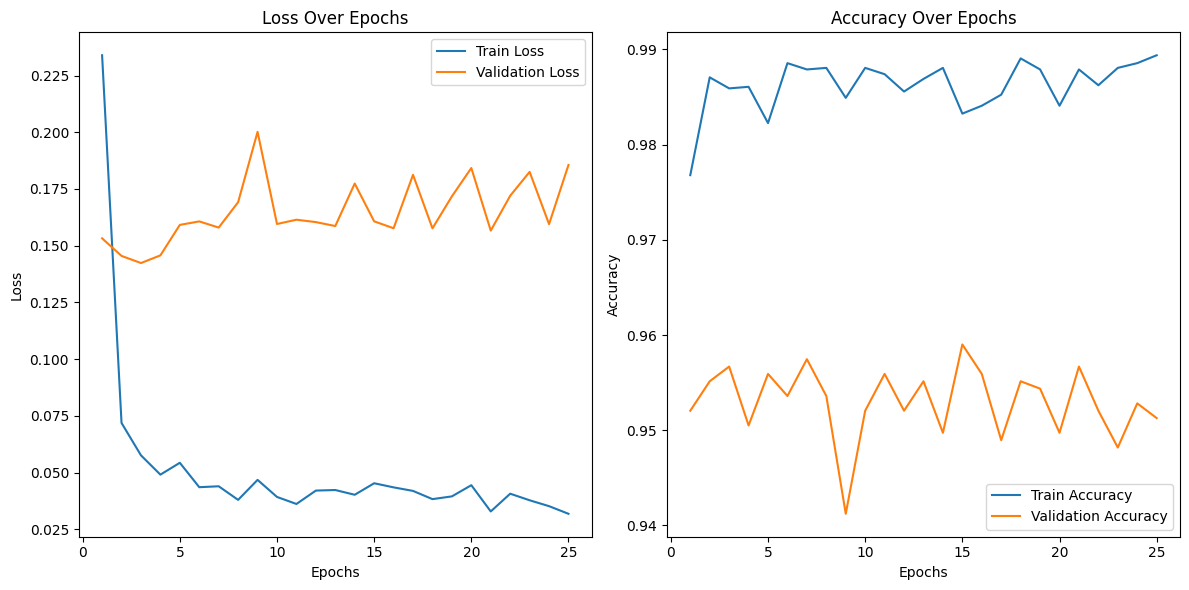

In [13]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

In [14]:
torch.save(model.state_dict(), "resnet18_bean_disease.pth")

In [15]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    return all_labels, all_preds

In [16]:
def plot_test_metrics(all_labels, all_preds, classes):
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
all_labels, all_preds = test_model(model, test_loader)

Test Accuracy: 0.9506


Classification Report:
              precision    recall  f1-score   support

         als       0.93      0.94      0.94       376
   bean_rust       0.97      0.89      0.93       376
     healthy       0.93      1.00      0.96       343
     unknown       1.00      1.00      1.00       201

    accuracy                           0.95      1296
   macro avg       0.96      0.96      0.96      1296
weighted avg       0.95      0.95      0.95      1296



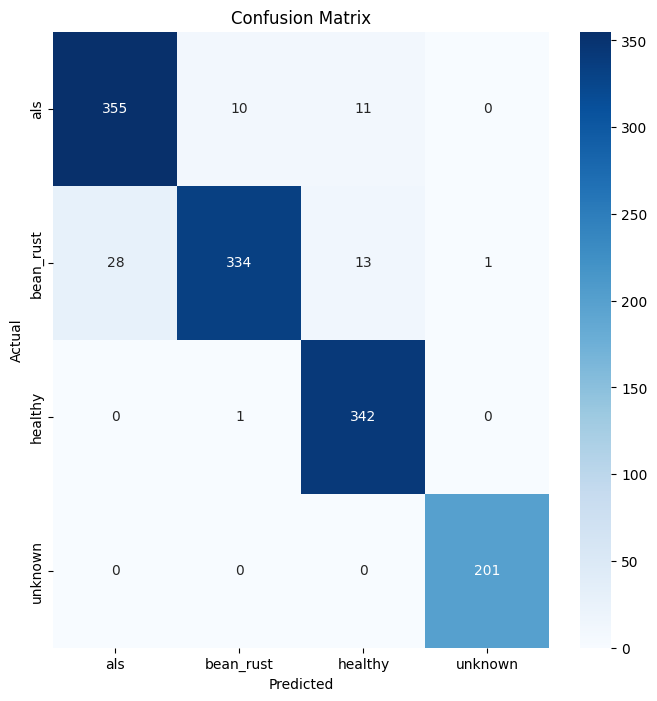

In [18]:
plot_test_metrics(all_labels, all_preds, test_loader.dataset.classes)